In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

KeyError: 'CONDA_DEFAULT_ENV'

In [1]:
import torch
import numpy as np
import tensorly as tl
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import sklearn.model_selection

import itertools

print(torch.cuda.is_available)
print(torch.cuda.device_count)
print(torch.cuda.current_device)
print(torch.cuda.get_device_name(0))

C:\Users\sabatini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<function is_available at 0x00000151FD38E050>
<function current_device at 0x00000151FD6A7EB0>
Quadro P2000


In [133]:
import sys
sys.path.append(r'C:\Users\sabatini\Documents\GitHub')
%load_ext autoreload
%autoreload 2
from tensor_regression import multinomial_tensor_regression as mtr

import tensor_regression.util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [394]:
labels = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/allLabels.mat', simplify_cells=True)['allLabels']
tensor = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/tensor.mat', simplify_cells=True)['tensor']
timepoints = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/timepoints_for_tensor.mat', simplify_cells=True)['timepoints_for_tensor']

In [395]:
print(f'Input data shapes:')
print(f'labels: {labels.shape}')
print(f'tensor: {tensor.shape}')
print(f'timepoints: {timepoints.shape}')

Input data shapes:
labels: (40,)
tensor: (1041, 450, 40)
timepoints: (450,)


(array([1110.,  170.,  150.,  110.,  120.,  120.,  270.,  420.,  500.,
         400.,  680., 1080.,  900.,  870.,  820.,  430.,  530.,  670.,
         560.,  760.,  450.,  800.,  380.,  180.,  170.,  180.,  180.,
         360.,  290.,  160.,  120.,  110.,  150.,  170.,  180.,  250.,
         230.,   80.,   60.,   50.,   80.,   50.,   70.,   60.,   90.,
          40.,   50.,   60.,   60.,   70.,  120.,  110.,   70.,  100.,
         100.,  110.,  140.,  110.,  190.,   80.,   60.,  130.,   50.,
          20.,   20.,    0.,   30.,   10.,   20.,   10.,   30.,   10.,
          30.,   20.,   20.,   20.,   20.,   40.,   20.,   40.,   20.,
          40.,   50.,   10.,   10.,   10.,   10.,   10.,   10.,   10.,
          10.,   10.,   20.,   10.,   10.,   20.,   10.,   10.,   20.,
         120.]),
 array([2.99480362e-16, 4.00000000e-02, 8.00000000e-02, 1.20000000e-01,
        1.60000000e-01, 2.00000000e-01, 2.40000000e-01, 2.80000000e-01,
        3.20000000e-01, 3.60000000e-01, 4.00000000e-01, 4.

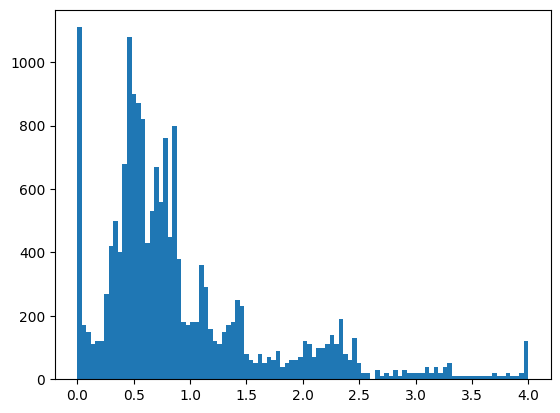

In [396]:
plt.figure()
plt.hist(tensor[0].reshape(-1), 100)

In [410]:
X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
X = (X - np.mean(X, axis=1)[:,None,:])
y = np.array(labels, dtype=np.int64)
print(f'X: {X.shape}, y: {y.shape}')

# y[y==1] = 0
# y[y>=2] = 1
# y[y==2] = 0
# y[y==3] = 1


DEVICE = tensor_regression.util.set_device(use_GPU=True)

u, c = np.unique(y, return_counts=True)
wei = c.sum() / c
wei = wei*4
print(wei)

hyperparameters = {}
hyperparameters['L2'] = [0.0125] #[0.0125] #[0.0005] #[0.0, 0.001, 0.002, 0.004, 0.01, 0.02, 0.04]
hyperparameters['lr'] = [0.007] #[0.005] #[0.05] #[0.0003, 0.001, 0.003, 0.01, 0.03]
hyperparameters['rank'] = [2] #[4] #[1,2,3,4]
hyperparameters['Bcp_init_scale'] = [0.625] #[0.625] #[0.5, 1.0, 2.0]
hyperparameters['non_negative'] = [[True, False, True]] #[[True, True, True]] #[[False, False, False], [True, False, False], [False, True, False], [True, True, False]]
hyperparameters['iteration'] = list(np.arange(1)) #list(np.arange(5))

results = {}
for ii, h_vals in enumerate(itertools.product(*hyperparameters.values())):
    h_dict = {key: hv for key, hv in zip(hyperparameters.keys(), h_vals)}
    print(f'hyperparameters: {h_dict}')

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

    cpmlr = mtr.CP_logistic_regression(
        X_train,
        y_train, 
        rank=h_dict['rank'],
        non_negative=h_dict['non_negative'],
        weights=None,
        Bcp_init=None,
        Bcp_init_scale=h_dict['Bcp_init_scale'],
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # cpmlr.fit(
    #     lambda_L2=0.000, 
    #     max_iter=200, 
    #     tol=1e-50, 
    #     patience=10,
    #     weights=weights,
    #     verbose=2,
    #     running_loss_logging_interval=1,
    #     LBFGS_kwargs={
    #         'lr' : 10000, 
    #         'max_iter' : 20, 
    #         'max_eval' : None, 
    #         'tolerance_grad' : 1e-07, 
    #         'tolerance_change' : 1e-09, 
    #         'history_size' : 100, 
    #         'line_search_fn' : "strong_wolfe"
    #     }
    #  )

    cpmlr.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=40000, 
        tol=1e-5, 
        patience=100,
        weights=wei,
        verbose=2,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

    # # print(time.time() - tic)
    # print(f'loss: {cpmlr.loss_running[-1]}')

    # loss_all.append(cpmlr.loss_running[-1])

    logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
    cm = mtr.confusion_matrix(pred, y_test)
    acc_val = np.sum(np.diag(cm))/np.sum(cm)

    logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train = np.sum(np.diag(cm))/np.sum(cm)

    # Make neuron- and time-shuffled data
    X_train_shuffled = X_train.copy()
    X_train_shuffled = X_train_shuffled[:, np.random.permutation(X_train_shuffled.shape[1]), :]
    X_train_shuffled = X_train_shuffled[:, :, np.random.permutation(X_train_shuffled.shape[2])]
    logit, pred = cpmlr.predict(X=X_train_shuffled, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled = np.sum(np.diag(cm))/np.sum(cm)

    # Make trial-shuffled cm
    logit, pred = cpmlr.predict(X=X_train[np.random.permutation(X_train.shape[0])], y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled_trial = np.sum(np.diag(cm))/np.sum(cm)
    
    print(f'Accuracy test: {acc_val:.3f}, Accuracy train: {acc_train:.3f}, Accuracy neuron and time shuffled: {acc_train_shuffled:.3f}, Accuracy trial shuffled: {acc_train_shuffled_trial:.3f}')

    
    results[ii] = {}
    results[ii]['acc_val'] = acc_val
    results[ii]['acc_train'] = acc_train
    results[ii]['acc_train_shuffleNeurXTime'] = acc_train_shuffled
    results[ii]['acc_train_shuffleTrial'] = acc_train_shuffled_trial
    results[ii]['loss_running'] = cpmlr.loss_running
    results[ii]['loss_train_final'] = cpmlr.loss_running[-1]
    results[ii]['hyperparameters'] = h_dict


X: (40, 1041, 450), y: (40,)
device: 'cuda'
[16. 16. 16. 16.]
hyperparameters: {'L2': 0.0125, 'lr': 0.007, 'rank': 4, 'Bcp_init_scale': 0.625, 'non_negative': [True, False, True], 'iteration': 0}
Iteration: 0, Loss: 1.6537690162658691
Iteration: 1, Loss: 1.396020531654358
Iteration: 2, Loss: 1.3930675983428955
Iteration: 3, Loss: 1.3898485898971558
Iteration: 4, Loss: 1.3863269090652466
Iteration: 5, Loss: 1.3825289011001587
Iteration: 6, Loss: 1.3786182403564453
Iteration: 7, Loss: 1.374582290649414
Iteration: 8, Loss: 1.370439052581787
Iteration: 9, Loss: 1.3662077188491821
Iteration: 10, Loss: 1.3619036674499512
Iteration: 11, Loss: 1.357540488243103
Iteration: 12, Loss: 1.3531286716461182
Iteration: 13, Loss: 1.348677396774292
Iteration: 14, Loss: 1.3441946506500244
Iteration: 15, Loss: 1.3396869897842407
Iteration: 16, Loss: 1.335160255432129
Iteration: 17, Loss: 1.3306169509887695
Iteration: 18, Loss: 1.3260557651519775
Iteration: 19, Loss: 1.3214421272277832
Iteration: 20, Loss:

Accuracy TRAIN: 1.0


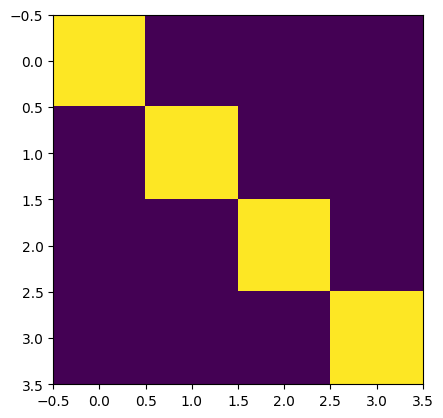

In [411]:
logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
cm = mtr.confusion_matrix(pred, y_train)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TRAIN: {acc}')

plt.figure()
plt.imshow(cm)

Accuracy TEST: 1.0


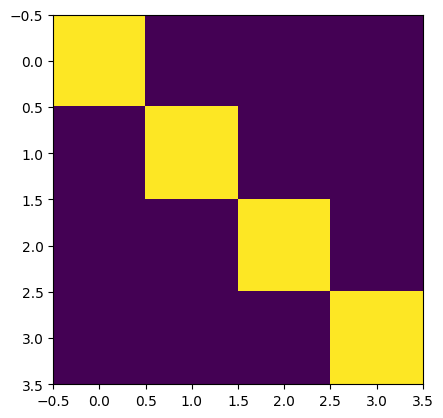

In [412]:
logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
cm = mtr.confusion_matrix(pred, y_test)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TEST: {acc}')

plt.figure()
plt.imshow(cm)

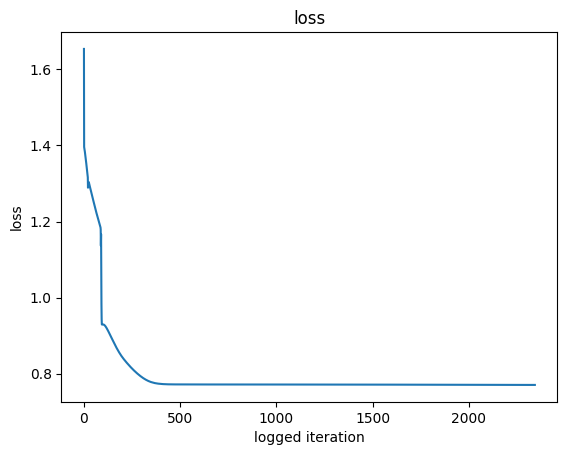

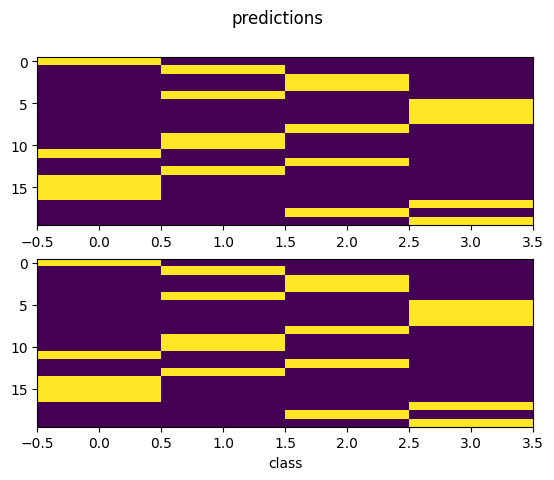

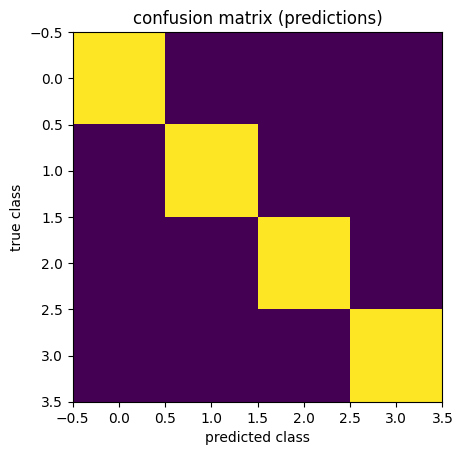

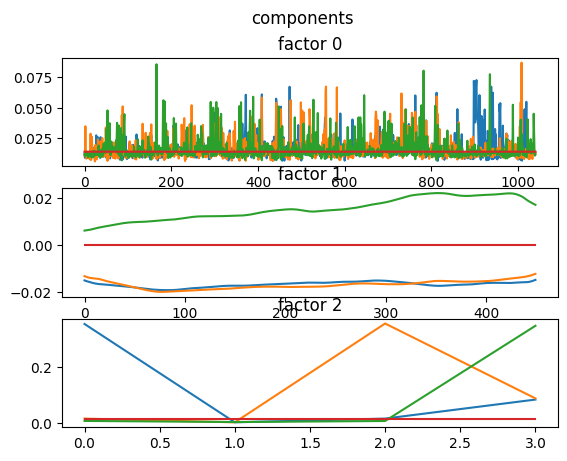

In [413]:
cpmlr.plot_outputs()

In [94]:
cpmlr.make_confusion_matrix()

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.]]),
 0.5)